### TRDB Downloader

In [1]:
%load_ext autoreload

import os
import numpy as np
import pandas as pd 
import eikon as ek

from IPython.display import display

In [2]:
def initialize_eikon(filename='credentials'):
    '''load and set the api key:
    eikon api proxy must be running.'''
    f = open(filename+'.txt','r')
    appid = f.readline()
    ek.set_app_id(appid)
    f.close()
    return 

initialize_eikon()

In [3]:
def request_data_loop(assets,ts,te,fields,nob=None,maxrep=3,msg=False):
    '''
    Due to the max. limit in the number of data points per request, 
    this function splits up a huge request of all assets in the whole timeframe
    into small request blocks of several assets, and if necessary, even
    several consecutive timeframes.
    
    params:
    :assets,ts,te,fields,nob: see main function
    :maxrep: integer, the maximum number of repetitions an attempt is made
        fetch incomplete data.
    '''
    
    # separate request blocks 
    if nob is None:
        # by default, see number of blocks (nob) is set such that we 
        # split the total asset list into blocks of size 10.
        nob = int(np.ceil(len(assets)/10.0))
        if msg: 
            print 'Number of Blocks automatically set to:',nob
            print
    else:
        # if nob is specified, make sure that the smallest resulting 
        # blocksize is 1 asset / block.
        nob = min(nob,len(assets))
        
    # resulting list of block indices for splitting the total assets list
    req = [int(i) for i in np.linspace(0,len(assets),nob)]
    
    if msg: 
        print 'Request Start. Blocksize:',req[1]-req[0]
        print 
    
    # initial values
    rep = 1
    notall = True 
    te_rep = te
    
    # data is collected in this dataframe
    DF = pd.DataFrame()
    
    # as long as the maximum number of allowed repetitions is not reached, 
    # and we did not download all data, yet, do...
    while (rep<=maxrep) and notall:
        
        notall = False
        if msg: print 'Repetition: %s, Request Window: [%s,%s]'%(rep,ts,te_rep)
        
        # sub-dataframe for current download repetition
        DFrep = pd.DataFrame()
        
        # set request end time to data start time of previous loop iteration
        # in the first iteration this is the overall request end date
        te = te_rep
        
        # if several assets are downloaded per block (which is usually the case)
        # the start dates back to which we receive data might vary for the assets
        # we collect all of these start dates and later on take the maximum
        t0list = []
        
        # request the timeframe for all assets separately
        for i in range(1,len(req)):
            
            if msg: print '\r',np.round(req[i]*1.0/req[-1]*100,2),'%',
            
            # current asset request block
            al = [str(a) for a in assets.index.tolist()[req[i-1]:req[i]]] 
                        
            try:
                # download data with eikon command
                df = ek.get_timeseries(al,fields=fields,corax = 'adjusted', 
                                       start_date=ts, end_date=te,
                                       calendar='tradingdays')
                            
            except Exception as e:
                # if there is an exception on an asset, we ignore and continue
                if msg: print e
                e = str(e)
                n = e.count('No data available for the requested date range')
                # if no data is available for any asset in a block anymore
                if n == len(al):
                    if msg: 
                        print
                        print 'No-Data-Available Request Block: %s'%al
                    df = pd.DataFrame()
                continue

            # drop all-NaN-asset-columns of [CLOSE,VALUE,...]
            df = df.dropna(how='all',axis=1)            
            
            if isinstance(df,pd.DataFrame) and (not df.empty):
                
                # append start time of fetched data to control list
                t0list.append(pd.Timestamp(df.index[0]))

                # join different asset request blocks with the same timeframe
                DFrep = pd.concat([DFrep,df],axis=1).sort_index(ascending=True)
            
        # check whether first date is in closeness to start date [+-5days]
        dr = pd.date_range(pd.Timestamp(ts)-5*pd.Timedelta('1d'),pd.Timestamp(ts)+5*pd.Timedelta('1d'))
        dr = [str(d.date()) for d in dr]
        
        # get latest asset data start time (asset with least data is the limiting one)
        temax = max(t0list)

        # if the data is not fetched completely back to the ts we specified,...
        if str(temax.date()) not in dr:

            # set the 'not all data fetched' parameter to True 
            # this ensures that the next repetition will be started
            notall = True

            # set next request end date one day prior to current available start date of data
            te_rep = str(((temax)-pd.Timedelta('1d')).date())

            if msg: print
            if msg: print 'Data only fetched back to: %s. Attempting Retry.'%temax.date()
        
        # if all data in the [ts,te] timeframe was fetched, continue...
        else: 
            
            notall = notall or False
            
            if msg:
                print
                print 'Data completely fetched from %s on.'%df.index[0].date()
            
        # join different timerange data timeframes
        
        # JC: found an issue here with the concatenation
        # it somehow originates when an entire list of requested assets does not
        # contain any data in the specified timeframe,
        # did not find a fix, yet
        DF = pd.concat([DF,DFrep],axis=0)
        
        DF.sort_index(ascending=True,inplace=True)
        DF.drop_duplicates(inplace=True)
        
        if msg: print 
        
        rep +=1
            
    return DF

def TR_download_price_data(assets,ts=None,te=None,save=False,name='fco0_all',nob=None,fields=['CLOSE','VALUE'],maxrep=3,msg=False,filt=True):
    '''
    Main Function arranging the download of price data for a list of assets 
    via the TR Eikon API Proxy. 
    
    The procedure divides the given list of asset RICs (IDs of assets in the TR Database)
    into a number of request blocks (nob) of size N/nob (for N total requested assets).
    Then, for each request block the data in the full timeframe [ts,te] is downloaded. 
    The reason why we need to split the request into blocks is that we can only request 
    a maximum number of data points in each request. Therefore, it can also happen that
    the timeframe [ts,te] is chosen too large. Then, only data from a time ts1>ts is supplied.
    In this case the parameter maxrep determines how often we retry to get ealier data 
    between [ts,ts1-1]. 
    
    params:
    
    :assets: pd.DataFrame with RIC index (and columns [Name,Category])
    :ts,te: timeframe [ts,te], specify as strings
    :save: saves to csv, bool
    :name: if save=True, specifies the name of the csv to save to
    :nob: integer number of download blocks, if None, nob is automatically set 
        such that a request blocksize of 10 results.
    :fields: string list of the fields to request. leave default options to get price data.
    :filt: bool, whether or not to filter corrupt raw data for some known problems
    
    Note:
        Be careful that assets does not contain duplicate RICs.
    '''
    
    # timeframe to download [yesterday-1year:yesterday]
    if te is None:
        te = pd.Timestamp('today').round('d')-pd.Timedelta('1d')
    else:
        te = min(pd.Timestamp(te),pd.Timestamp('today')-pd.Timedelta('1d'))
    if ts is None:
        ts = te - 370 * pd.Timedelta('1d')
        
    dr = pd.date_range(ts,te,freq='B')
    ts = str(dr[0].date())
    te = str(dr[-1].date())
    if msg: print 'Timeframe: ',ts,te
    if msg: print 'Total Number of requested RICs: ', len(assets)
    
    # download data iteratively for all assets in the specified timeframe
    DF = request_data_loop(assets,ts,te,fields,nob,maxrep,msg)
    
    # At this point, we should have downloaded all requested asset data 
    # in the desired timeframe. If not, we have a coding error somewhere.
    
    # The DF is returned with a multiindex as columns. We replace it 
    # by just the RICs as column names. (This should be done only if we
    # request single fields. If, for instance, we request several fields, 
    # like price and volume, it should be left as a multiindex.)
    if (len(fields)==1) or (fields==['CLOSE','VALUE']):
        newcols=list()
        for col in DF.columns:
            if isinstance(DF.columns,pd.core.indexes.multi.MultiIndex):
                col = col[0]
            newcols.append(col)
        DF.columns = newcols

    notworking = []
    if filt:
        # data post-processing I:
        # eliminate all timeseries that contain more than 5% the same number
        # notworking is a list in which we collect all the asset IDs that were 
        # eliminated in post processing
        for col in DF.columns.tolist():
            dfc = DF[col]
            if dfc.value_counts(normalize=True).iloc[0]>=0.05:
                if msg: print 'Removed Asset %s because of too many constant values.'%col
                DF.drop(col,axis=1,inplace=True)
                notworking.append(col)
    
    if filt:
        # data post-processing II
        # sort out time series with pos/neg one-day jump returns exceeding 30%
        # calculate absolute first order approx returns in percent
        R = np.abs(100.*(np.exp(np.log(DF).diff(1))-1))
        # locate jump-assets
        ja = R[R>30.].replace(np.nan,0).sum(axis=0)
        ja = ja[ja!=0].index.tolist()
        DF.drop(ja,axis=1,inplace=True)
        notworking.extend(ja)
            
    # compare the theoretically requested asset RICs to the actually 
    # really downloaded ones. add the ones missing to the notworking list.
    nw = set(assets.index.tolist())-set(DF.columns.tolist())
    notworking.extend(nw)
    
    # prints a summary message of the procedure
    if msg: _message(notworking,assets,DF)
        
    # post-processing III: formatting
    # timestamp index
    DF.index = [pd.Timestamp(date) for date in DF.index]
    # ensure business days only (pay attention here if you request data of daily open markets)
    DF = DF.loc[pd.date_range(DF.index[0],DF.index[-1],freq='B')] 
    # fill up nan values (on weekends and other gaps etc.), can be discussed to be removed.
    DF.fillna(method='ffill',inplace=True)
    DF.fillna(method='bfill',inplace=True) # fill end 
    
    if msg:
        print 'Final Timeframe: [%s,%s]'%(DF.index[0].date(),DF.index[-1].date())
        print 'Done.'
    
    if save:
        _save_data_to_csv(DF,assets,name)
        
    return DF, notworking

def _save_data_to_csv(DF,assets,name):
    # save working RICs and asset data to separate csv files
    
    path = 'data/'
    
    te = pd.Timestamp(DF.index[-1])
    filename = name+'_' + str(te.date().month) + str(te.date().year)
    DF.to_csv(path + filename + '.csv',header=True) 
    
    # save all working asset RICs in an extra file
    assets.loc[DF.columns.tolist()].to_csv(path + filename+'_working_RIC.csv',index=False)
    
    print 'Saved.'
    return None

def _message(notworking,assets,DF):
    print 'Request End.'
    if len(notworking)>0:
        print 'Some assets failed to download / are all equal elements:'
        print notworking
        print 'Total Request: ',len(assets.index)
        print 'Obtained Assets: ',len(DF.columns) 
        print 'Not Working: ',len(notworking)
    else:
        print 'All asset data successfully downloaded.'

#### Requests

In [5]:
# import lists of [RIC,Name,Category]-Excel Sheets
assets = pd.read_excel('Example Asset List.xlsx',index_col=0)
assets.head()

,Name,Category
RIC,,
.IBBEU0027,iBoxx EUR Austria Index,FI - Government Bonds
.IBBEU002E,iBoxx EUR Belgium Index,FI - Government Bonds
.IBBEU00B8,iBoxx EUR Finland Index,FI - Government Bonds
.IBBEU00BA,iBoxx EUR France Index,FI - Government Bonds
.IBBEU00C4,iBoxx EUR Germany Index,FI - Government Bonds


In [8]:
%%time
ts = '2015-01-01'
te = '2018-06-01'
save = True
name = 'test'
nob = None
fields = ['CLOSE','VALUE']
maxrep = 50
msg = True
filt = True
DF,notworking = TR_download_price_data(assets,ts,te,save,name,nob,fields,maxrep,msg,filt)

 Timeframe:  2015-01-01 2018-06-01
Total Number of requested RICs:  100
Number of Blocks automatically set to: 10

Request Start. Blocksize: 11

Repetition: 1, Request Window: [2015-01-01,2018-06-01]
100.0 %       
Data only fetched back to: 2017-05-31. Attempting Retry.

Repetition: 2, Request Window: [2015-01-01,2017-05-30]
100.0 %       
Data only fetched back to: 2016-05-27. Attempting Retry.

Repetition: 3, Request Window: [2015-01-01,2016-05-26]
100.0 %       
Data only fetched back to: 2015-05-26. Attempting Retry.

Repetition: 4, Request Window: [2015-01-01,2015-05-25]
100.0 %       
Data completely fetched from 2015-01-02 on.

Request End.
All asset data successfully downloaded.
Final Timeframe: [2015-01-01,2018-06-01]
Done.
Saved.
Wall time: 49 s


#### Plot Functions

In [9]:
import matplotlib.pyplot as plt

def plot_assets_for_inspection(DF,N=10):
    # Plot N assets per plot to check how the time series data looks
    # Try out setting filt to False or True in the download function,
    # and see if the data changes 
    
    DF = DF.copy()
    
    print 'Total Number of Assets: %s'%len(DF.columns)
    
    for i in range(len(DF.columns)//N + 1): # // floor division
        dfp = DF[DF.columns[N*i:N*(i+1)]]
        if dfp.empty:
            continue
        ax = dfp.plot(logy=True,figsize=(12,5))
        ax.legend(loc=3,ncol=5,frameon=False,fontsize=11)
        ax.grid(True,linestyle=':')
        plt.show()
        
    return

Total Number of Assets: 100


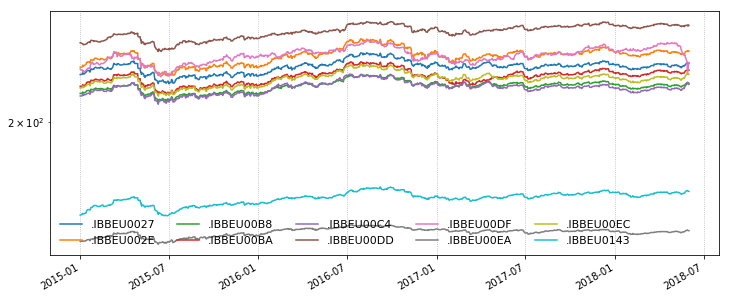

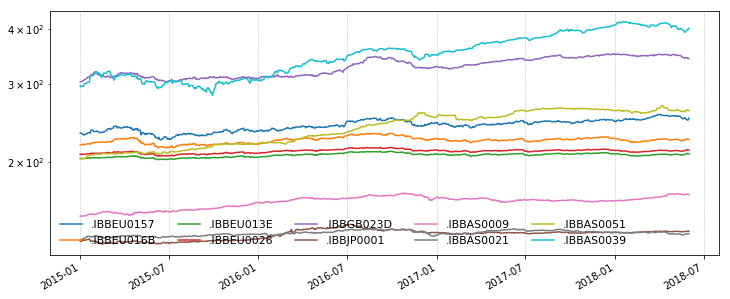

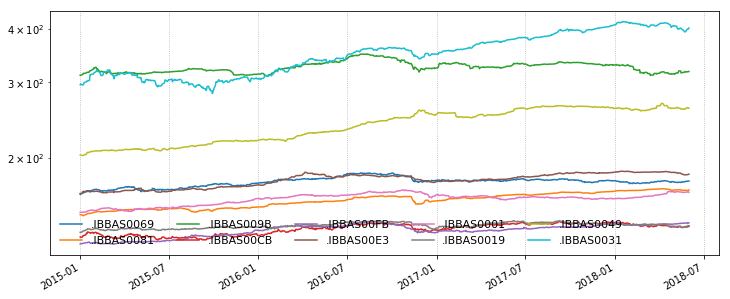

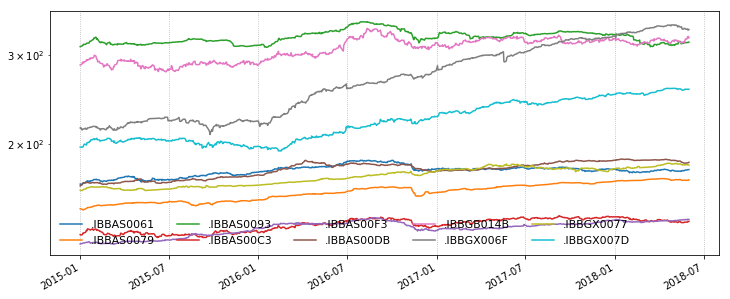

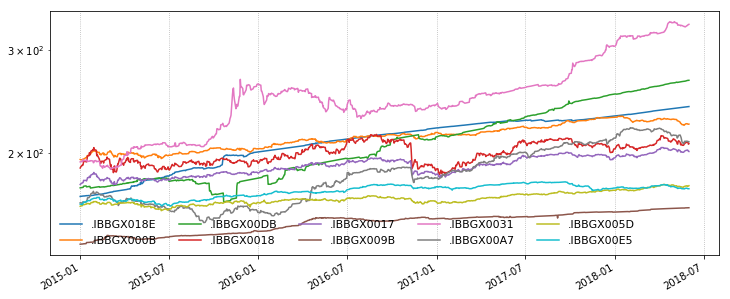

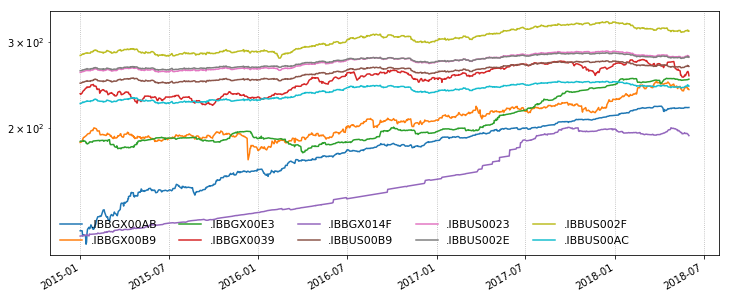

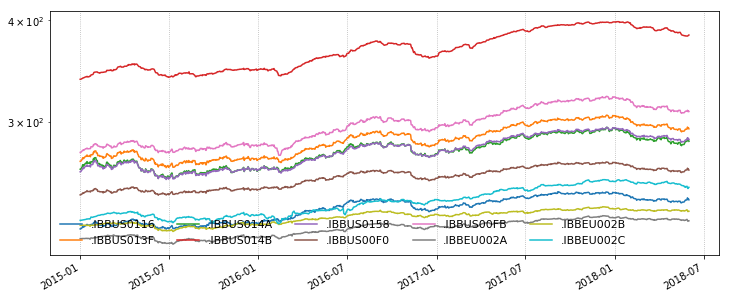

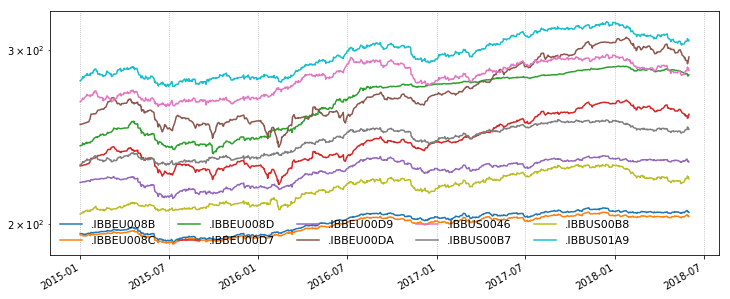

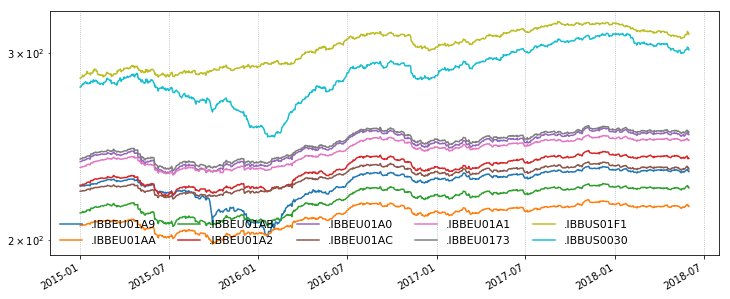

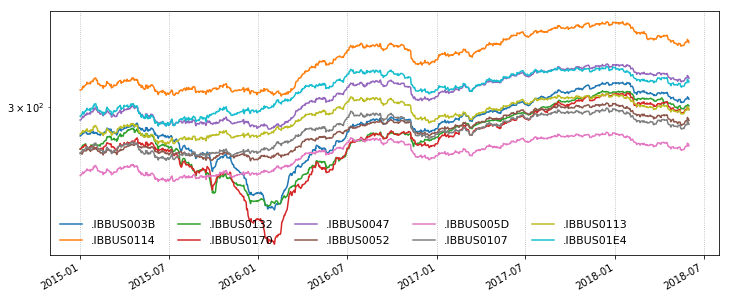

In [11]:
plot_assets_for_inspection(DF,N=10)